<a href="https://colab.research.google.com/github/ACobo98/DataAnalysis_MachineLearning/blob/main/Autonomus_IntroMachineLearning_Embryos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Autonomous Activity: Classical ML Pipeline on Embryo Timelapse

**Dataset:** Six time-lapse `.tif` stacks — **2 controls** and **4 mutants**  
**Biological types:**
- **control**: `Control1`, `Control2`
- **mutantA**: `Mutant1`, `Mutant3`
- **mutantB**: `Mutant2`, `Mutant4`

📁 **Dataset:** [Google Drive Link](https://drive.google.com/drive/folders/1_qxqm-v5yCrme3pAW2rjyOOXIeQDuV54?usp=drive_link)

You will build a complete classical ML pipeline using **per-frame image features**.

## Learning goals
1. **Regression** — predict developmental time (frame index).  
2. **Classification** — (a) 6-class embryo ID, (b) 3-class biological type.  
3. **Clustering** — explore structures and compare with biological types.  
4. **Dimensionality Reduction** — PCA, t‑SNE, UMAP; plot per-embryo **trajectories**.  
5. **Cross‑Validation** — use GroupKFold to avoid leakage across embryos.  
6. **Bias–Variance** — analyze learning and validation curves.

> **No leakage rule:** never mix frames of the **same embryo** across train and test folds.



## 0) Environment setup

**Task:** Install the required packages and verify imports.


In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gdown
import os
import glob


from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, learning_curve, validation_curve
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.datasets import make_regression, make_classification, make_blobs, load_iris
from sklearn.model_selection import GroupKFold
from sklearn.neighbors import KNeighborsRegressor
from skimage.measure import regionprops_table, label
from skimage.filters import threshold_otsu
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import skew, kurtosis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from skimage.io import imread
from skimage.filters import sobel


## 1) Download the 6 TIFF stacks

**Task:** Place your files under a local `data/` folder with the exact names below.  
If using Colab, you may download the shared folder with `gdown`:

- `data/Control1.tif`
- `data/Control2.tif`
- `data/Mutant1.tif`   *(mutantA)*
- `data/Mutant2.tif`   *(mutantB)*
- `data/Mutant3.tif`   *(mutantA)*
- `data/Mutant4.tif`   *(mutantB)*


In [3]:
FOLDER_ID = "1_qxqm-v5yCrme3pAW2rjyOOXIeQDuV54"

os.makedirs("data")

!gdown --folder https://drive.google.com/drive/folders/$FOLDER_ID -O data


Retrieving folder contents
Processing file 1a85fmd7QWAqAXdl2qSBAElgb_kd_eQNc Control1.tif
Processing file 1oa4UjMY8gJ1QRMQ0cMyR9GyNbGU9yAAz Control2.tif
Processing file 1pqISdlzcrGhxhlRf8nbjzwe-zQe_VgGk Mutant1.tif
Processing file 1f7mik8NqKxvIFSdhbqYvcJ3JiSnjsjtE Mutant2.tif
Processing file 12HgJria1Pntxw1AFEn7QpUyd8BxzS1kQ Mutant3.tif
Processing file 1NJMLyDD4N9dSblwcPo5IUhFCo-ZCGABI Mutant4.tif
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1a85fmd7QWAqAXdl2qSBAElgb_kd_eQNc
To: /content/data/Control1.tif
100% 18.1M/18.1M [00:00<00:00, 32.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1oa4UjMY8gJ1QRMQ0cMyR9GyNbGU9yAAz
To: /content/data/Control2.tif
100% 18.1M/18.1M [00:00<00:00, 24.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1pqISdlzcrGhxhlRf8nbjzwe-zQe_VgGk
To: /content/data/Mutant1.tif
100% 18.1M/18.1M [00:00<00:00, 28.7MB/s]
Downloading...
From: 


## 2) Load data and define labels

**Task:**
1. Confirm each `.tif` is a stack of shape `(T, H, W)`.
2. Build a tidy `DataFrame` with **one row per frame** and the columns:
   - `embryo_id` ∈ {Control1, Control2, Mutant1, Mutant2, Mutant3, Mutant4}
   - `type3` ∈ {`control`, `mutantA`, `mutantB`}
   - `frame` ∈ {0..T-1}
   - Per-frame features (computed in the next cell)
3. Print basic counts by `embryo_id` and `type3`.


In [30]:
tif_files = sorted(glob.glob("data/*.tif"))
print("Names of TIF files: ",tif_files,"\n")
#Shape files confimation
for file_path in tif_files:
  #Numpy Array
  image_stack = imread(file_path)
  print(image_stack.shape)

#DataFrame Building:

#Function to extract features of each frame image
def extract_features(image_frame):
    """Calculates selected shape, intensity, and texture features from a 2D image.
    Features: area, perimeter, eccentricity, mean_intensity, std_intensity,
    contrast, correlation, homogeneity, energy."""

    # --- 1. Segmentation: Create a binary mask to identify the embryo ---
    # Find the optimal threshold to separate the embryo from the background.
    thresh = threshold_otsu(image_frame)

    # Create the mask: pixels brighter than the threshold are True (1), others are False (0).
    mask = image_frame > thresh

    # Check if the mask contains any white pixels. If not, segmentation failed.
    if np.sum(mask) == 0:
        # Return a dictionary of NaNs (Not a Number) to handle the missing data gracefully.
        return {
            'area': np.nan,
            'perimeter': np.nan,
            'eccentricity': np.nan,
            'mean_intensity': np.nan,
            'std_intensity': np.nan,
            'contrast': np.nan,
            'correlation': np.nan,
            'homogeneity': np.nan,
            'energy': np.nan
        }

    # 'label' is a required step for 'regionprops' to identify connected objects.
    label_image = label(mask)

    # --- 2. Shape Features ---
    # Calculate area, perimeter, and eccentricity all at once.
    props = regionprops_table(label_image, properties=('area', 'perimeter', 'eccentricity'))

    # Convert the results from arrays to single numbers.
    shape_features = {key: props[key][0] for key in props}

    # --- 3. Intensity Features ---
    # Select only the pixels of the original image that belong to the embryo.
    embryo_pixels = image_frame[mask]

    intensity_features = {
        'mean_intensity': np.mean(embryo_pixels),
        'std_intensity': np.std(embryo_pixels)
    }

    # --- 4. Texture Features ---
    # GLCM works on integer images (0-255), so we must convert the image format first.
    image_uint8 = image_frame.astype(np.uint8)

    # Calculate the Gray-Level Co-occurrence Matrix (GLCM).
    glcm = graycomatrix(image_uint8, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)

    # Calculate texture properties from the GLCM.
    texture_features = {
        'contrast': graycoprops(glcm, 'contrast')[0, 0],
        'correlation': graycoprops(glcm, 'correlation')[0, 0],
        'homogeneity': graycoprops(glcm, 'homogeneity')[0, 0],
        'energy': graycoprops(glcm, 'energy')[0, 0]
    }

    # --- 5. Combine and return the final dictionary ---
    all_features = {**shape_features, **intensity_features, **texture_features}

    return all_features


#Dictionary to assign each frame to correct type
type_map = {
    'Control1': 'control',
    'Control2': 'control',
    'Mutant1':  'mutantA',
    'Mutant3':  'mutantA',
    'Mutant2':  'mutantB',
    'Mutant4':  'mutantB'
}

all_frames_data=[]

for file_path in tif_files:
  #Delete .tif from the name of each file and save them in a new list
  embryo_id = os.path.basename(file_path).replace('.tif', '')
  #Save a new list with the type of each file
  type3 = type_map[embryo_id]
  #Numpy Array of each file
  image_stack = imread(file_path)
  #Extract the number of frames of each file
  num_frames = image_stack.shape[0]

  #Loop to go over each frame from each file
  for frame_idx in range(num_frames):

    #Create a register for each frame
    frame_info = {
        'embryo_id': embryo_id,
        'type3': type3,
        'frame': frame_idx
    }
    #current frame image
    current_frame_image = image_stack[frame_idx, :, :]
    features = extract_features(current_frame_image)
    full_record = {**frame_info, **features}
    #Save it in the list
    all_frames_data.append(full_record)

total_rows_with_nan = df[feature_cols].isnull().any(axis=1).sum()

print(f"\nNumber of frames with Nans:: {total_rows_with_nan}")
print(f"% frames with Nans: {total_rows_with_nan / len(df) * 100:.2f}%")

df = pd.DataFrame(all_frames_data)
df = df.dropna()
print(df.shape, "\n")
print(df.head(), "\n")
print(df.tail())


Names of TIF files:  ['data/Control1.tif', 'data/Control2.tif', 'data/Mutant1.tif', 'data/Mutant2.tif', 'data/Mutant3.tif', 'data/Mutant4.tif'] 

(450, 200, 200)
(450, 200, 200)
(450, 200, 200)
(450, 200, 200)
(450, 200, 200)
(450, 200, 200)

Number of frames with Nans:: 0
% frames with Nans: 0.00%
(2698, 12) 

  embryo_id    type3  frame    area   perimeter  eccentricity  mean_intensity  \
0  Control1  control      0  7594.0  599.813275      0.494927      147.433800   
1  Control1  control      1  7392.0  522.529004      0.469930      149.781250   
2  Control1  control      2  7513.0  546.120887      0.437375      149.508019   
3  Control1  control      3  7421.0  539.049819      0.453105      148.420719   
4  Control1  control      4  7473.0  527.215295      0.458379      150.807440   

   std_intensity    contrast  correlation  homogeneity    energy  
0      35.428628  468.004923     0.936100     0.762073  0.742731  
1      35.625919  415.266000     0.943528     0.771042  0.752501  


## 2.1) Feature matrix and grouping (anti-leakage)

**Task:**
- Select `feature_cols` (use at least the ones built above).
- Build:  
  `X` (features), `y_reg = frame`, `y_id6 = embryo_id`, `y_type3 = type3`  
- Define `groups = embryo_id` to be used in GroupKFold.


In [118]:
feature_cols = [
    'area',
    'perimeter',
    'eccentricity',
   # 'mean_intensity',
   # 'std_intensity',
    'contrast',
   # 'correlation',
    'homogeneity',
   # 'energy'
]

X = df[feature_cols]
y_reg = df['frame']
y_id6 = df['embryo_id']
y_type3 = df['type3']
groups = df['embryo_id']


## 3) Supervised Learning — Regression (frame index)

**Task :**
1. Implement 3 models using `Pipeline`:
   - `LinearRegression` (+ `StandardScaler`)
   - `Ridge(alpha)` — try `alpha ∈ {0.1, 1, 10}`
   - `KNeighborsRegressor` — try `n_neighbors ∈ {3,5,7,11}` with `MinMaxScaler`
2. Use **GroupKFold** with `n_splits = min(6, #embryos)` to evaluate **MAE** and **R²**.
3. Report mean metrics for each model and **compare**.
4. Plot **True vs Predicted** for one representative split.


In [119]:
n_embryos = len(np.unique(groups))
gkf = GroupKFold(n_splits=min(6, n_embryos)) #Tool to evaluate the MAE and R^2

models_to_test = [
    ('LinearRegression', Pipeline([
        ('scaler', StandardScaler()),
        ('reg', LinearRegression())
    ])),
    ('Ridge(alpha=0.1)', Pipeline([
        ('scaler', StandardScaler()),
        ('reg', Ridge(alpha=0.1, random_state=42))
    ])),
    ('Ridge(alpha=1)', Pipeline([
        ('scaler', StandardScaler()),
        ('reg', Ridge(alpha=1, random_state=42))
    ])),
    ('Ridge(alpha=10)', Pipeline([
        ('scaler', StandardScaler()),
        ('reg', Ridge(alpha=10, random_state=42))
    ])),
    ('KNN(k=3)', Pipeline([
        ('scaler', MinMaxScaler()),
        ('reg', KNeighborsRegressor(n_neighbors=3))
    ])),
    ('KNN(k=5)', Pipeline([
        ('scaler', MinMaxScaler()),
        ('reg', KNeighborsRegressor(n_neighbors=5))
    ])),
    ('KNN(k=7)', Pipeline([
        ('scaler', MinMaxScaler()),
        ('reg', KNeighborsRegressor(n_neighbors=7))
    ])),
    ('KNN(k=11)', Pipeline([
        ('scaler', MinMaxScaler()),
        ('reg', KNeighborsRegressor(n_neighbors=11))
    ]))
]

results = []
for name, model_pipe in models_to_test:
    # R²
    scores_r2 = cross_val_score(model_pipe, X, y_reg, cv=gkf, groups=groups, scoring='r2')

    # MAE (mean_absolute_error)
    scores_mae = cross_val_score(model_pipe, X, y_reg, cv=gkf, groups=groups, scoring='neg_mean_absolute_error')

    results.append({
        'Model': name,
        'R2 Mean': np.mean(scores_r2),
        'R2 Std': np.std(scores_r2),
        'MAE Mean': -np.mean(scores_mae)
    })

results_df = pd.DataFrame(results).sort_values(by='R2 Mean', ascending=False)
print(results_df)


              Model   R2 Mean    R2 Std   MAE Mean
7         KNN(k=11)  0.451259  0.558873  62.749376
6          KNN(k=7)  0.401509  0.581762  65.536781
5          KNN(k=5)  0.362096  0.595326  67.561998
3   Ridge(alpha=10)  0.343587  0.286196  82.186563
2    Ridge(alpha=1)  0.337675  0.292498  82.594069
1  Ridge(alpha=0.1)  0.337063  0.293150  82.636514
0  LinearRegression  0.336995  0.293223  82.641247
4          KNN(k=3)  0.327341  0.607557  69.339523


Generating plots using embryo 'Mutant4' as the test set.
Training each model and generating its plot...


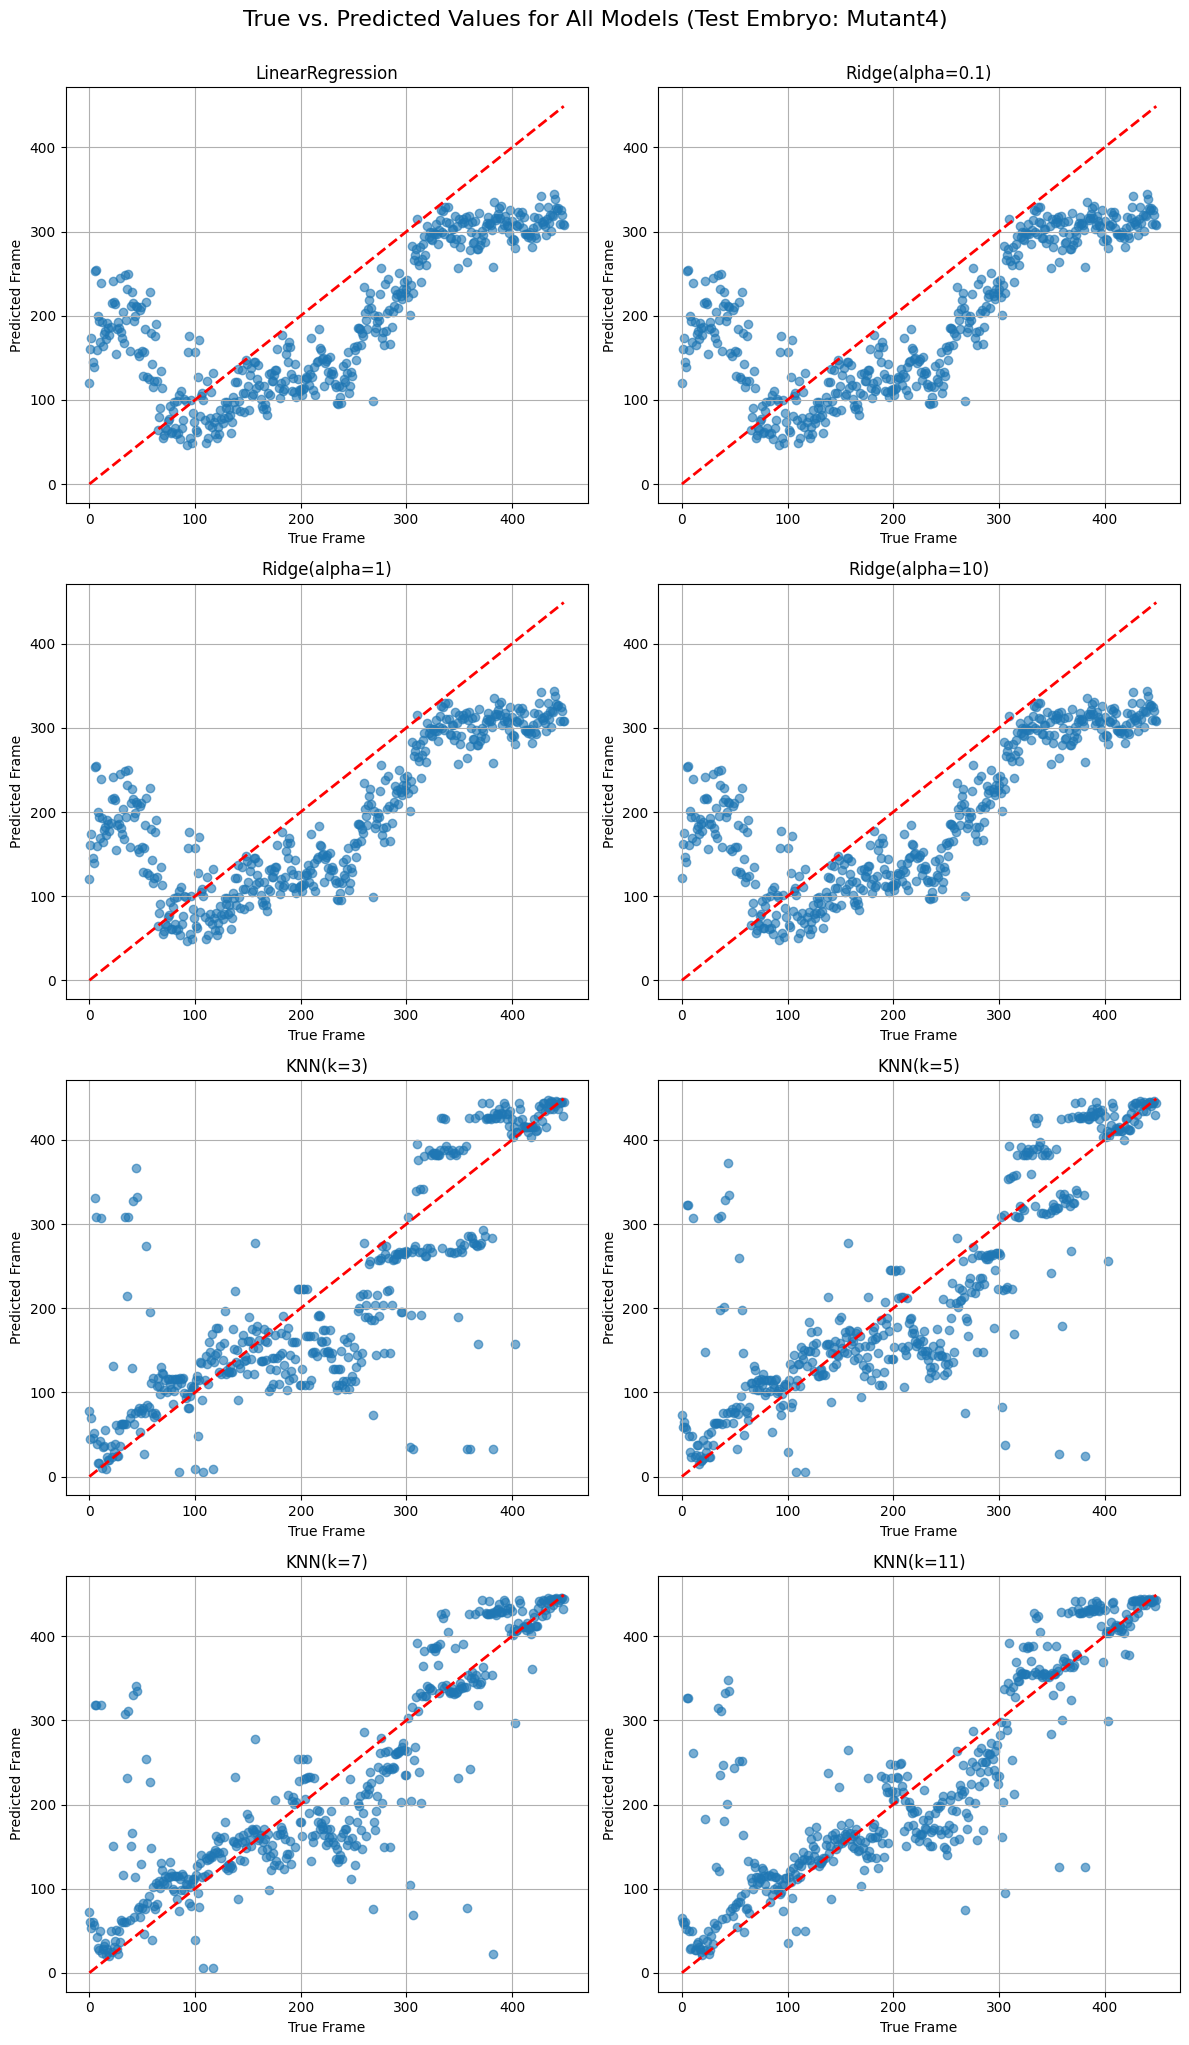

In [69]:
train_idx, test_idx = next(gkf.split(X, y_reg, groups))

# Use the indices to create the training and testing sets.
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y_reg.iloc[train_idx], y_reg.iloc[test_idx]

# Identify which embryo is being used for the test set in this split.
test_embryo = np.unique(groups.iloc[test_idx])[0]
print(f"Generating plots using embryo '{test_embryo}' as the test set.")


# --- 2. Create Subplots and Loop Through Models ---
# Create a figure and a 4x2 grid of subplots. 'figsize' adjusts the overall size.
fig, axes = plt.subplots(4, 2, figsize=(12, 20))
# 'axes.ravel()' flattens the 4x2 grid into a simple list to make looping easier.
axes = axes.ravel()

print("Training each model and generating its plot...")

# Loop through each model we defined earlier.
for i, (name, model_pipe) in enumerate(models_to_test):

    # --- 3. Fit Model and Make Predictions ---
    # Fit the current model pipeline on the training data.
    model_pipe.fit(X_train, y_train)

    # Predict the frame index for the test data.
    y_pred = model_pipe.predict(X_test)

    # --- 4. Plot on the Corresponding Subplot ---
    # Select the correct subplot from our grid.
    ax = axes[i]

    # Create the scatter plot of true vs. predicted values.
    ax.scatter(y_test, y_pred, alpha=0.6)

    # Add the diagonal red line for reference (perfect prediction).
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', lw=2)

    # Set titles and labels for this specific subplot.
    ax.set_title(name)
    ax.set_xlabel("True Frame")
    ax.set_ylabel("Predicted Frame")
    ax.grid(True)

# --- 5. Finalize and Show the Plot ---
# This adjusts spacing between plots to prevent titles from overlapping.
fig.tight_layout()
plt.suptitle(f"True vs. Predicted Values for All Models (Test Embryo: {test_embryo})", y=1.02, fontsize=16)
plt.show()


## 4) Supervised Learning — Classification

Two tasks (do **both**):
- **ID-6:** predict `embryo_id` (6 classes)
- **Type-3:** predict `type3` (3 classes: control, mutantA, mutantB)

**Task:**
1. Implement 3 classifiers with `Pipeline`:
   - `LogisticRegression(max_iter=1000)`
   - `KNeighborsClassifier`
   - `SVC(kernel='rbf')`
2. Evaluate with **GroupKFold**. Metrics: **Accuracy** and **F1‑macro**.
3. Compare **ID-6** vs **Type-3** (expect Type-3 to be easier).
4. Add confusion matrices.


In [114]:
# --- Create a list of the classifiers we will test ---
# All models will be placed in a Pipeline with a scaler for best practice.
classifiers_to_test = [
    ('LogisticRegression', Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=1000, random_state=42))
    ])),
    ('KNeighborsClassifier', Pipeline([
        ('scaler', StandardScaler()),
        ('clf', KNeighborsClassifier())
    ])),
    ('SVC (RBF)', Pipeline([
        ('scaler', StandardScaler()),
        ('clf', SVC(kernel='rbf', random_state=42))
    ]))
]


def evaluate_classification_task(X_data, y_data, groups_data, models, cv_strategy):
    """
    Runs cross-validation for a list of classification models and returns a results dataframe.
    """
    results = []
    print(f"--- Evaluating Task for target: {y_data.name} ---")

    for name, model_pipe in models:
        # Evaluate Accuracy
        scores_acc = cross_val_score(model_pipe, X_data, y_data, cv=cv_strategy, groups=groups_data, scoring='accuracy')

        # Evaluate F1-macro
        scores_f1 = cross_val_score(model_pipe, X_data, y_data, cv=cv_strategy, groups=groups_data, scoring='f1_macro')

        results.append({
            'Model': name,
            'Accuracy Mean': np.mean(scores_acc),
            'F1-macro Mean': np.mean(scores_f1)
        })

    results_df = pd.DataFrame(results).sort_values(by='Accuracy Mean', ascending=False)
    return results_df


feature_cols = [
    'area',
   # 'perimeter',
    'eccentricity',
   # 'mean_intensity',
   # 'std_intensity',
   # 'contrast',
    'correlation',
    'homogeneity',
    'energy'
]

X = df[feature_cols]

# --- Run evaluation for the 6-class embryo ID task ---
results_id6 = evaluate_classification_task(X, y_id6, groups, classifiers_to_test, gkf)
print("\n Results for ID-6 Classification (Predicting Embryo ID):")
print(results_id6)

# --- Run evaluation for the 3-class biological type task ---
results_type3 = evaluate_classification_task(X, y_type3, groups, classifiers_to_test, gkf)
print("\n Results for Type-3 Classification (Predicting Biological Type):")
print(results_type3)

--- Evaluating Task for target: embryo_id ---

 Results for ID-6 Classification (Predicting Embryo ID):
                  Model  Accuracy Mean  F1-macro Mean
0    LogisticRegression            0.0            0.0
1  KNeighborsClassifier            0.0            0.0
2             SVC (RBF)            0.0            0.0
--- Evaluating Task for target: type3 ---

 Results for Type-3 Classification (Predicting Biological Type):
                  Model  Accuracy Mean  F1-macro Mean
2             SVC (RBF)       0.601655       0.257289
1  KNeighborsClassifier       0.578150       0.246403
0    LogisticRegression       0.512224       0.197307


Training models and generating confusion matrices...


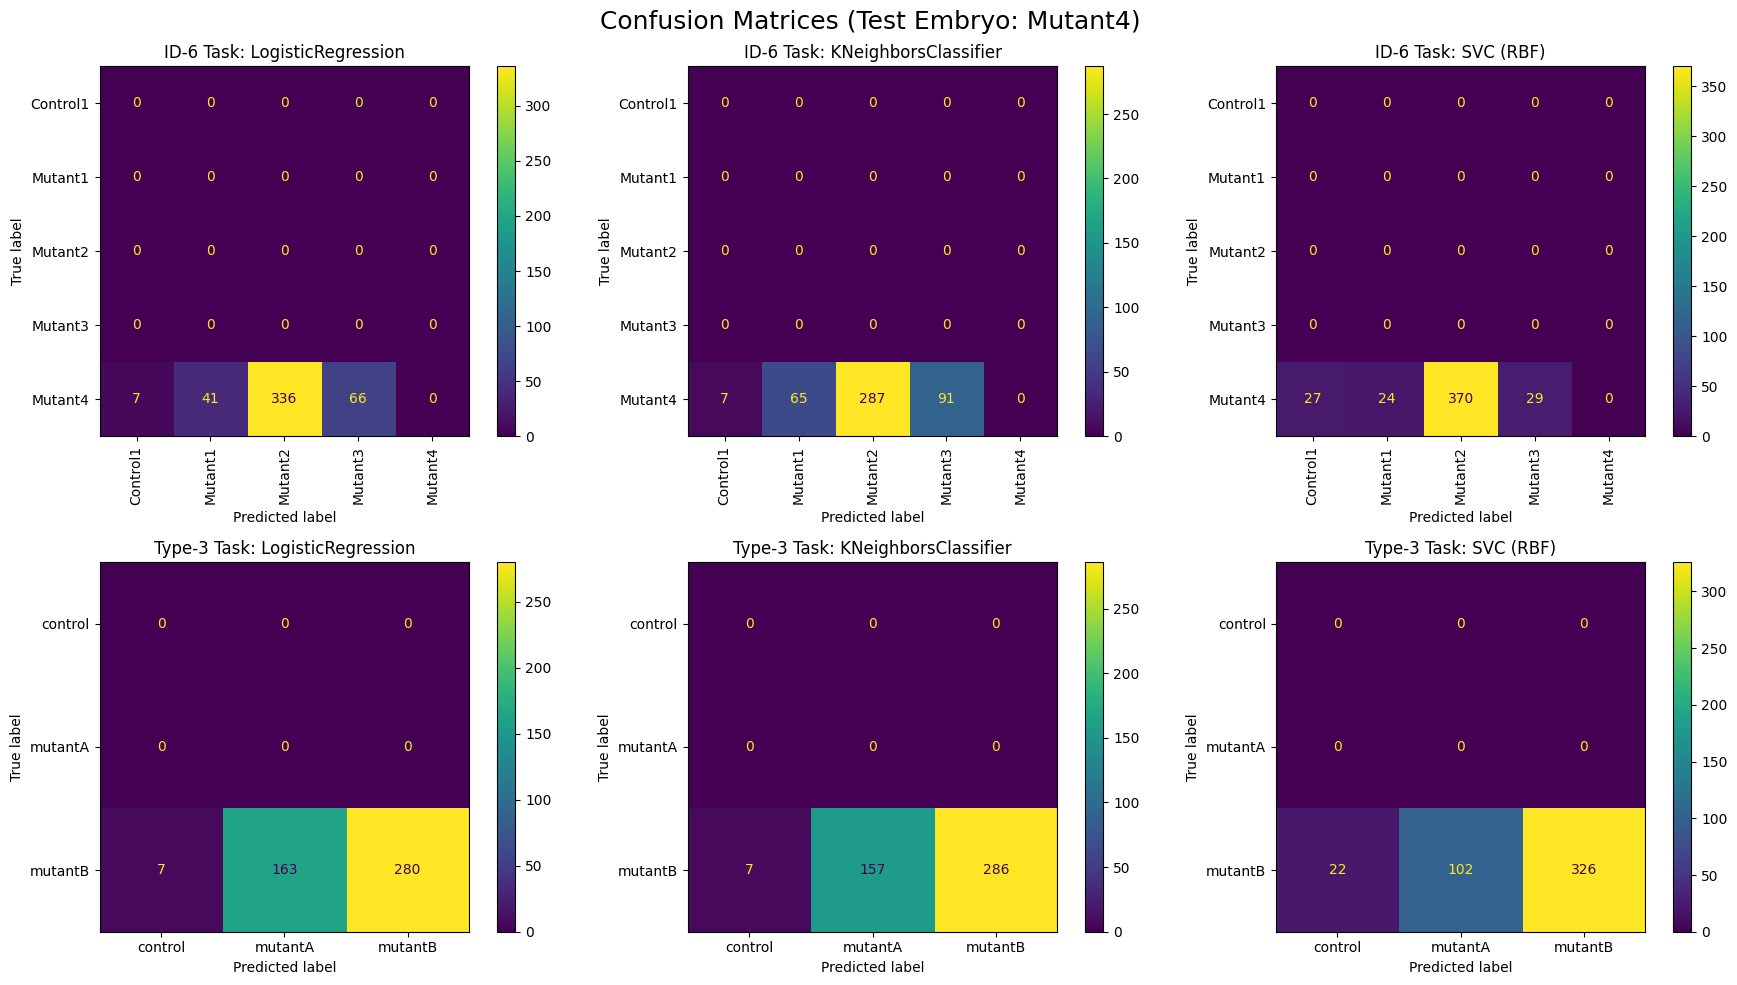

In [115]:
# --- 1. Get a single representative split ---
# This ensures we are visualizing the performance on the same set of test data for all models.
train_idx, test_idx = next(gkf.split(X, y_reg, groups))
test_embryo = np.unique(groups.iloc[test_idx])[0]

# --- 2. Create the grid of subplots ---
# We need 2 rows (one for each task) and 3 columns (one for each classifier).
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle(f'Confusion Matrices (Test Embryo: {test_embryo})', fontsize=18)

print("Training models and generating confusion matrices...")

# --- 3. Loop through each classifier to generate its matrices ---
for i, (name, model_pipe) in enumerate(classifiers_to_test):

    # --- Task 1: ID-6 (The "impossible" task) ---
    # Fit the model on the training data for the ID-6 task.
    model_pipe.fit(X.iloc[train_idx], y_id6.iloc[train_idx])

    # Plot the confusion matrix on the correct subplot in the first row.
    ConfusionMatrixDisplay.from_estimator(
        model_pipe,
        X.iloc[test_idx],
        y_id6.iloc[test_idx],
        ax=axes[0, i],
        xticks_rotation='vertical'
    )
    axes[0, i].set_title(f'ID-6 Task: {name}')

    # --- Task 2: Type-3 (The "possible" task) ---
    # Fit the model on the training data for the Type-3 task.
    model_pipe.fit(X.iloc[train_idx], y_type3.iloc[train_idx])

    # Plot the confusion matrix on the correct subplot in the second row.
    ConfusionMatrixDisplay.from_estimator(
        model_pipe,
        X.iloc[test_idx],
        y_type3.iloc[test_idx],
        ax=axes[1, i]
    )
    axes[1, i].set_title(f'Type-3 Task: {name}')

# Adjust layout to prevent titles from overlapping and display the plot.
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.tight_layout()
plt.show()


## 5) Unsupervised Learning — Clustering

**Task (no solutions provided):**
1. Standardize `X` with `StandardScaler`.
2. Apply **KMeans** and **AgglomerativeClustering** with:
   - `n_clusters=3` (biological types)
   - (Optional) `n_clusters=6` (embryo IDs)
3. Compute **silhouette score** (unsupervised metric).
4. Build crosstabs: **cluster vs `type3`** and **cluster vs `embryo_id`** (for interpretation only).


In [104]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score


feature_cols = [
    'area',
    #'perimeter',
    'eccentricity',
   # 'mean_intensity',
   # 'std_intensity',
    #'contrast',
  #  'correlation',
    #'homogeneity',
   # 'energy'
]

X = df[feature_cols]

# Standardize the Data
# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Clustering for n_clusters = 3
n_clusters = 3


# KMeans Clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)


# Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=n_clusters)
agglo_labels = agglo.fit_predict(X_scaled)


# Compute Silhouette Scores
# This metric evaluates clustering quality without using the true labels.
kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)
agglo_silhouette = silhouette_score(X_scaled, agglo_labels)


print(f"KMeans Silhouette Score: {kmeans_silhouette:.3f}")
print(f"Agglomerative Clustering Silhouette Score: {agglo_silhouette:.3f}\n")


# --- 5. Build Crosstabs for Interpretation ---


# Create a temporary DataFrame for easier crosstab creation
df_clusters = pd.DataFrame({
    'embryo_id': groups,
    'type3': y_type3,
    'KMeans_Cluster': kmeans_labels,
    'Agglo_Cluster': agglo_labels
})


print("KMeans:")
print(pd.crosstab(df_clusters['KMeans_Cluster'], df_clusters['type3']))
print("\nAgglomerative Clustering:")
print(pd.crosstab(df_clusters['Agglo_Cluster'], df_clusters['type3']))

KMeans Silhouette Score: 0.536
Agglomerative Clustering Silhouette Score: 0.533

KMeans:
type3           control  mutantA  mutantB
KMeans_Cluster                           
0                   289      414      439
1                   450        3        7
2                   161      481      454

Agglomerative Clustering:
type3          control  mutantA  mutantB
Agglo_Cluster                           
0                  454        3        7
1                  155      470      438
2                  291      425      455



## 6) Dimensionality Reduction + Trajectories

**Task :**
1. Compute **PCA(2)**, **t‑SNE(2)**, and **UMAP(2)** on standardized `X`.
2. Scatter-plot colored by `type3` (optionally also by `embryo_id`).
3. **Trajectories:** for each `embryo_id`, sort by `frame` and **connect** points in 2D.
4. Comment on which embedding separates **types** more clearly and which trajectories look smoother or diverge.


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


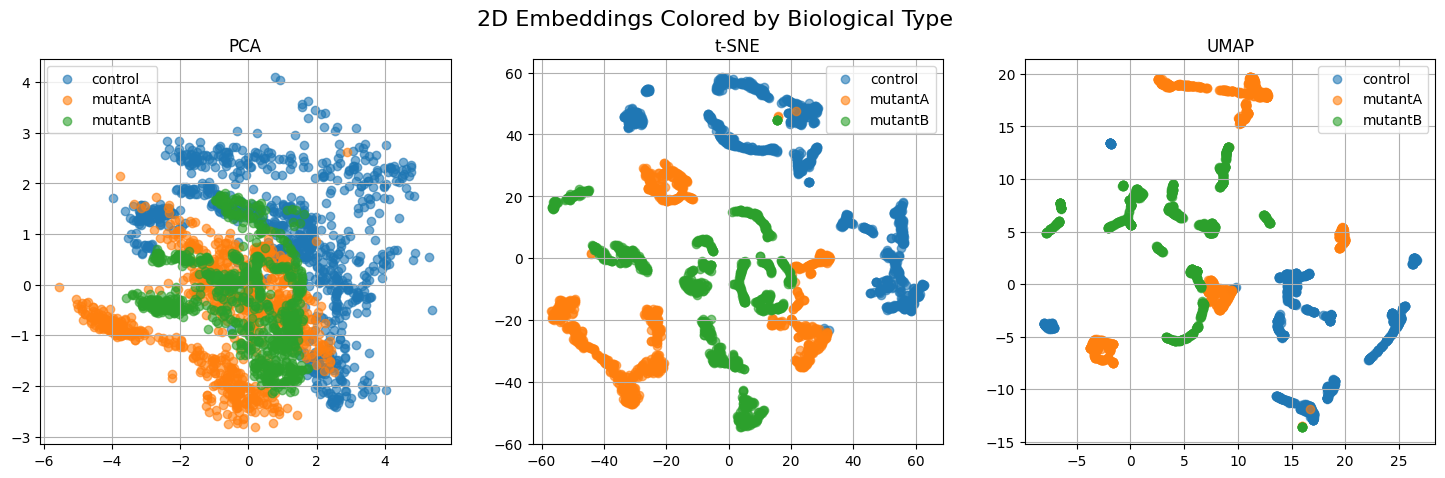

In [120]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import pandas as pd
import matplotlib.pyplot as plt

feature_cols = [
    'area',
    'perimeter',
    'eccentricity',
    'mean_intensity',
    'std_intensity',
    'contrast',
    'correlation',
    'homogeneity',
    'energy'
]

X = df[feature_cols]

#Standardize the Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# UMAP
umap_reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
X_umap = umap_reducer.fit_transform(X_scaled)

df_2d = pd.DataFrame({
    'PCA_1': X_pca[:, 0], 'PCA_2': X_pca[:, 1],
    'tSNE_1': X_tsne[:, 0], 'tSNE_2': X_tsne[:, 1],
    'UMAP_1': X_umap[:, 0], 'UMAP_2': X_umap[:, 1],
    'type3': y_type3,
    'embryo_id': groups,
    'frame': y_reg
})

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('2D Embeddings Colored by Biological Type', fontsize=16)
methods = {'PCA': ('PCA_1', 'PCA_2'), 't-SNE': ('tSNE_1', 'tSNE_2'), 'UMAP': ('UMAP_1', 'UMAP_2')}

for ax, (name, (x_col, y_col)) in zip(axes, methods.items()):
    for type_label in df_2d['type3'].unique():
        subset = df_2d[df_2d['type3'] == type_label]
        ax.scatter(subset[x_col], subset[y_col], label=type_label, alpha=0.6)
    ax.set_title(name)
    ax.legend()
    ax.grid(True)
plt.show()

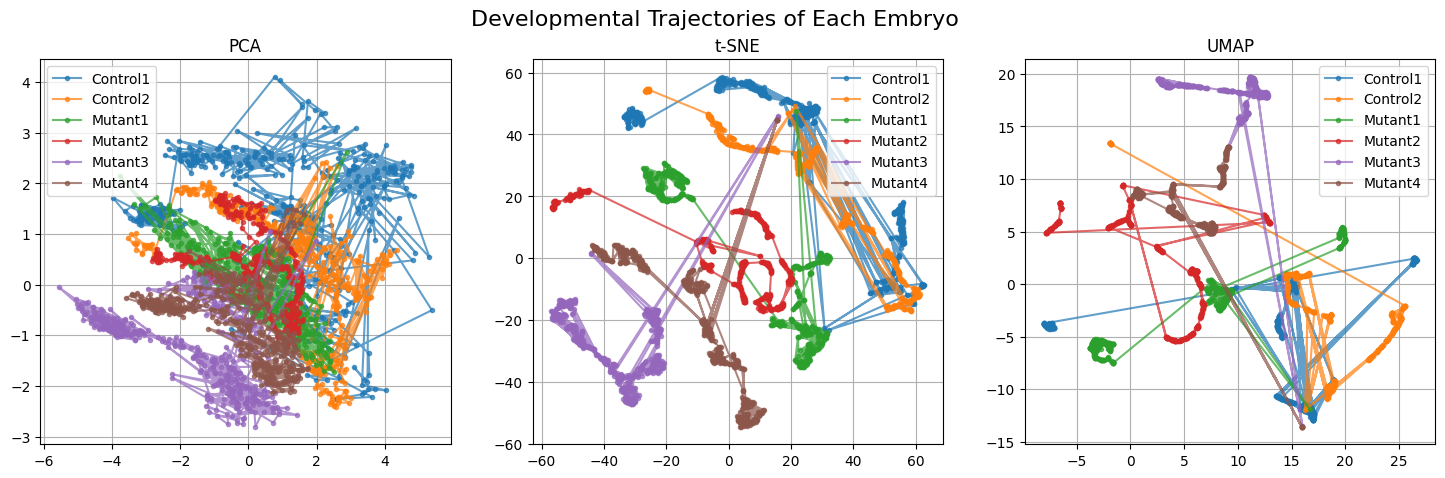

In [121]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Developmental Trajectories of Each Embryo', fontsize=16)

for ax, (name, (x_col, y_col)) in zip(axes, methods.items()):
    for embryo_label in df_2d['embryo_id'].unique():
        subset = df_2d[df_2d['embryo_id'] == embryo_label].sort_values(by='frame')
        ax.plot(subset[x_col], subset[y_col], 'o-', label=embryo_label, alpha=0.7, markersize=3)
    ax.set_title(name)
    ax.legend()
    ax.grid(True)
plt.show()


## 7) Cross‑Validation without leakage vs naïve split

**Task :**
1. Use **GroupKFold** (groups = `embryo_id`) with `LogisticRegression` for the **Type-3** task.
2. Compare against a naïve frame-wise `train_test_split` (this leaks information).
3. Report **Accuracy** and **F1‑macro** for both; discuss overestimation from leakage.


In [123]:
from sklearn.metrics import accuracy_score, f1_score
model_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])


# GroupKFold Evaluation
gkf = GroupKFold(n_splits=6)

# Calculate cross-validated scores
honest_acc_scores = cross_val_score(model_pipe, X, y_type3, cv=gkf, groups=groups, scoring='accuracy')
honest_f1_scores = cross_val_score(model_pipe, X, y_type3, cv=gkf, groups=groups, scoring='f1_macro')

honest_acc_mean = np.mean(honest_acc_scores)
honest_f1_mean = np.mean(honest_f1_scores)

print(f"GroupKFold Accuracy: {honest_acc_mean:.3f}")
print(f"GroupKFold F1-macro: {honest_f1_mean:.3f}\n")


# train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_type3, test_size=0.2, random_state=42, stratify=y_type3)

# Fit the model on the training set
model_pipe.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_pipe.predict(X_test)

# Calculate scores
leaky_acc = accuracy_score(y_test, y_pred)
leaky_f1 = f1_score(y_test, y_pred, average='macro')

print(f"Leaky Accuracy: {leaky_acc:.3f}")
print(f"Leaky F1-macro: {leaky_f1:.3f}\n")

GroupKFold Accuracy: 0.433
GroupKFold F1-macro: 0.211

Leaky Accuracy: 0.939
Leaky F1-macro: 0.939




## 8) Bias–Variance and Overfitting

**Task (no solutions provided):**
1. Choose `DecisionTreeClassifier` or `KNN` for the **Type-3** task.
2. **Learning curve:** use `learning_curve` with GroupKFold. Plot training size vs Accuracy (train vs validation).
3. **Validation curve:** plot hyperparameter vs Accuracy (e.g., `max_depth` for a tree, or `n_neighbors` for KNN).
4. Conclude: identify **high variance** (train ≫ val) or **high bias** (both low) and propose tuning (regularization, features, data, hyperparameters).


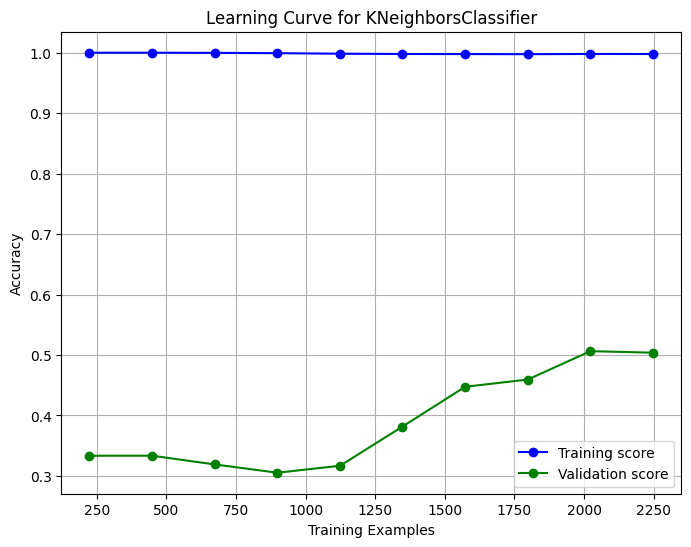

In [127]:
from sklearn.model_selection import learning_curve, validation_curve
model_to_analyze = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', KNeighborsClassifier())
])

# This function calculates train and test scores for different training set sizes.
train_sizes, train_scores, test_scores = learning_curve(
    estimator=model_to_analyze,
    X=X,
    y=y_type3,
    cv=gkf,
    groups=groups,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy'
)

# Calculate mean scores for plotting
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, 'o-', color="blue", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="green", label="Validation score")
plt.title("Learning Curve for KNeighborsClassifier")
plt.xlabel("Training Examples")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid()
plt.show()


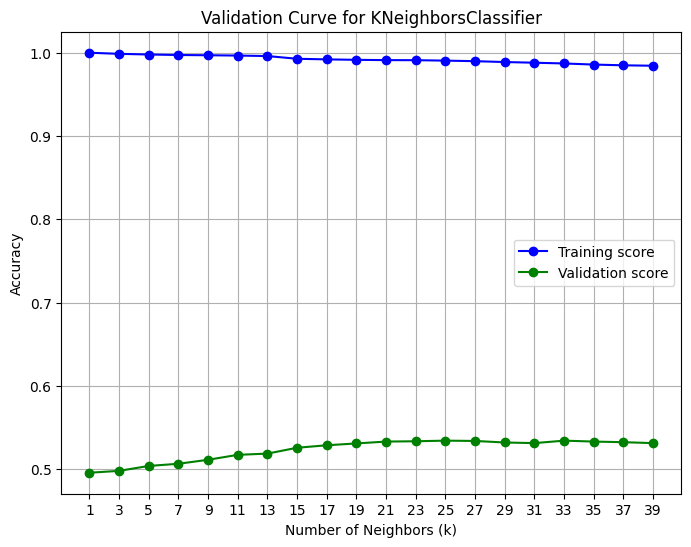

In [128]:
param_range = np.arange(1, 41, 2)

train_scores, test_scores = validation_curve(
    estimator=model_to_analyze,
    X=X,
    y=y_type3,
    param_name="clf__n_neighbors",
    param_range=param_range,
    cv=gkf,
    groups=groups,
    scoring="accuracy"
)

# Calculate mean scores for plotting
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

# Plot the validation curve
plt.figure(figsize=(8, 6))
plt.plot(param_range, train_mean, 'o-', color="blue", label="Training score")
plt.plot(param_range, test_mean, 'o-', color="green", label="Validation score")
plt.title("Validation Curve for KNeighborsClassifier")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid()
plt.xticks(param_range)
plt.show()


## 9) Deliverables

1. **Regression (frame):** best model + settings. Report GroupKFold **MAE** and **R²**; include a True vs Predicted plot.  
2. **Classification:** compare **ID-6** vs **Type-3**. Which models worked best? Include **Accuracy** and **F1‑macro**.  
3. **Clustering:** does `k=3` reveal types? How does `k=6` behave? Report silhouette and discuss crosstabs.  
4. **Dimensionality reduction:** which embedding separates **types** best? Show trajectories by `embryo_id` and discuss.  
5. **Cross‑Validation:** quantify overestimation from naïve split vs GroupKFold.  
6. **Bias–Variance:** interpret curves and propose next steps (regularization, features, data, hyperparameters).  

